## Policy Gradient for Pong

In [1]:
import numpy as np
import gym 
from gym import wrappers
import matplotlib.pyplot as plt
import tensorflow as tf
import time

In [2]:
class PolicyNetwork(object):
    def __init__(self, N_SIZE, h=200, gamma=0.99, eta=1e-3,decay=0.99, save_path = 'models2/pong.ckpt'):
        self.gamma = gamma
        self.save_path = save_path
        # Placeholders for passing state ...
        self.tf_x = tf.placeholder(dtype=tf.float32, shape=[None, N_SIZE*N_SIZE], name = "tf_x")
        self.tf_y = tf.placeholder(dtype=tf.float32, shape=[None, n_actions], name = "tf_y")
        self.tf_epr = tf.placeholder(dtype=tf.float32, shape=[None, 1], name = "tf_epr")
        
        # Weights
        xavier_l1 = tf.truncated_normal_initializer(mean=0,stddev=1. / N_SIZE, dtype=tf.float32)
        self.W1 = tf.get_variable("W1", [N_SIZE * N_SIZE, h], initializer=xavier_l1)
        xavier_l2 = tf.truncated_normal_initializer(mean=0,stddev=1. / np.sqrt(h), dtype=tf.float32)
        self.W2 = tf.get_variable("W2", [h, n_actions], initializer=xavier_l2)
        
        # Build Computation
        # tf reward processing (need tf_discounted_epr for policy gradient wizardry)
        tf_discounted_epr = self.tf_discount_rewards(self.tf_epr)
        tf_mean, tf_variance = tf.nn.moments(tf_discounted_epr, [0], shift=None, name="reward_moments")
        tf_discounted_epr -= tf_mean
        tf_discounted_epr /= tf.sqrt(tf_variance + 1e-6)
        
        # Define Optimizer, compute and apply gradients
        self.tf_aprob = self.tf_policy_forward(self.tf_x)
        loss = tf.nn.l2_loss(self.tf_y - self.tf_aprob)
        optimizer = tf.train.RMSPropOptimizer(eta, decay=decay)
        tf_grads = optimizer.compute_gradients(loss, var_list=tf.trainable_variables(), grad_loss=tf_discounted_epr)
        self.train_op = optimizer.apply_gradients(tf_grads)
        
        # Initialize Variables
        init = tf.global_variables_initializer()
        self.session = tf.InteractiveSession()
        self.session.run(init)
        self.load()
        
    def tf_discount_rewards(self, tf_r): # tf_r ~ [game_steps, 1]
        discount_f = lambda a, v: a * self.gamma + v
        tf_r_reverse = tf.scan(discount_f, tf.reverse(tf_r,[0]))
        tf_discounted_r = tf.reverse(tf_r_reverse, [0])
        return tf_discounted_r
    
    def tf_policy_forward(self, x): #x ~ [1,D]
        h = tf.matmul(x, self.W1)
        h = tf.nn.relu(h)
        logp = tf.matmul(h, self.W2)
        p = tf.nn.softmax(logp)
        return p
    
    def predict_UP(self,x):
        feed = {self.tf_x: np.reshape(x, (1,-1))}
        aprob = self.session.run(self.tf_aprob, feed)
        return aprob
    
    def update(self, feed):
        return self.session.run(self.train_op, feed)
    
    def load(self):
        self.saver = tf.train.Saver(tf.global_variables())
        load_was_success = True 
        try:
            save_dir = '/'.join(self.save_path.split('/')[:-1])
            ckpt = tf.train.get_checkpoint_state(Svae_dir)
            load_path = ckpt.model_checkpoint_path
            self.saver.restore(self.session, load_path)
        except:
            print("no saved model to load. starting new session")
            load_was_success = False
        else:
            print("loaded model: {}".format(load_path))
            saver = tf.train.Saver(tf.global_variables())
            episode_number = int(load_path.split('-')[-1])
    
    def save(self):
        self.saver.save(self.session, self.save_path, global_step=n)
        print("SAVED MODEL #{}".format(n))

In [3]:
# downsampling
def preprocess(I):
    """prepro 210*160*3 uint8 frame into 80*80 1D float vector"""
    I = I[35:195] # crop
    I = I [::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background type 1
    I[I == 109] = 0 # erase background type 2
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()

# testing for the above function
def test_preprocess():
    env = gym.make("Pong-v0")
    observation = env.reset()
    img = preprocess(observation)

    plt.imshow(observation)
    plt.show()
    print(observation.shape)

    plt.imshow(img)
    plt.show()
    print(img.shape)
    env.close()

# test_preprocess()

In [4]:
# Create Game Environment
env_name = "Pong-v0"
env = gym.make(env_name)
env = wrappers.Monitor(env, 'tmp/pong', force=True)
n_actions = env.action_space.n # number of possible actions

In [5]:
# Initializing Game and State(t-1), action, reward, state(t)
xs, rs, ys = [], [], []
obs = env.reset()
prev_x = None

running_reward = None
running_rewards = []
reward_sum = 0
n = 0
done= False
n_size = 80
num_episodes = 500

# Create agent
agent = PolicyNetwork(n_size)

Instructions for updating:
Colocations handled automatically by placer.
no saved model to load. starting new session


In [6]:
# training loop
while not done and n < num_episodes:
    # Preprocess the observation
    cur_x = preprocess(obs)
    x = cur_x - prev_x if prev_x is not None else np.zeros(n_size*n_size)
    prev_x = cur_x

    # Predict the action
    aprob = agent.predict_UP(x); aprob = aprob[0,:]
    action = np.random.choice(n_actions, p=aprob)
#     print(action)
    label = np.zeros_like(aprob) ; label[action] = 1

    # Step the environment and get new measurements
    obs, reward, done, info = env.step(action)
    env.render()
    reward_sum += reward

    # record game history
    xs.append(x) ; ys.append(label) ; rs.append(reward)

    if done:
        # update running reward
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        running_rewards.append(running_reward)
        feed = {agent.tf_x: np.vstack(xs), 
                agent.tf_epr: np.vstack(rs), 
                agent.tf_y: np.vstack(ys)}
        # print progress console
        if n % 10 == 0:
            print('ep {}: reward: {}, mean reward: {:3f}'.format(n, reward_sum, running_reward))
        else:
            print('\tep {}: reward: {}'.format(n, reward_sum))

        # Start next episode and save model
        xs, rs, ys = [], [], []
        obs = env.reset()
        n += 1 # the Next Episode

        reward_sum = 0
        if n% 50 == 0:
            agent.save()
        done = False

ep 0: reward: -19.0, mean reward: -19.000000
	ep 1: reward: -20.0
	ep 2: reward: -21.0
	ep 3: reward: -20.0
	ep 4: reward: -19.0
	ep 5: reward: -20.0
	ep 6: reward: -21.0
	ep 7: reward: -20.0
	ep 8: reward: -21.0
	ep 9: reward: -20.0
ep 10: reward: -21.0, mean reward: -19.124838
	ep 11: reward: -20.0
	ep 12: reward: -19.0
	ep 13: reward: -20.0
	ep 14: reward: -20.0
	ep 15: reward: -21.0
	ep 16: reward: -21.0
	ep 17: reward: -19.0
	ep 18: reward: -21.0
	ep 19: reward: -21.0
ep 20: reward: -21.0, mean reward: -19.238405
	ep 21: reward: -21.0
	ep 22: reward: -20.0
	ep 23: reward: -21.0
	ep 24: reward: -21.0
	ep 25: reward: -21.0
	ep 26: reward: -20.0
	ep 27: reward: -21.0
	ep 28: reward: -21.0
	ep 29: reward: -20.0
ep 30: reward: -21.0, mean reward: -19.378112
	ep 31: reward: -20.0
	ep 32: reward: -20.0
	ep 33: reward: -20.0
	ep 34: reward: -18.0
	ep 35: reward: -21.0
	ep 36: reward: -19.0
	ep 37: reward: -21.0
	ep 38: reward: -21.0
	ep 39: reward: -18.0
ep 40: reward: -20.0, mean reward:

ep 310: reward: -20.0, mean reward: -20.161555
	ep 311: reward: -21.0
	ep 312: reward: -19.0
	ep 313: reward: -18.0
	ep 314: reward: -18.0
	ep 315: reward: -21.0
	ep 316: reward: -20.0
	ep 317: reward: -20.0
	ep 318: reward: -18.0
	ep 319: reward: -20.0
ep 320: reward: -21.0, mean reward: -20.108452
	ep 321: reward: -20.0
	ep 322: reward: -21.0
	ep 323: reward: -21.0
	ep 324: reward: -21.0
	ep 325: reward: -19.0
	ep 326: reward: -21.0
	ep 327: reward: -20.0
	ep 328: reward: -18.0
	ep 329: reward: -21.0
ep 330: reward: -21.0, mean reward: -20.126439
	ep 331: reward: -21.0
	ep 332: reward: -20.0
	ep 333: reward: -21.0
	ep 334: reward: -21.0
	ep 335: reward: -20.0
	ep 336: reward: -19.0
	ep 337: reward: -20.0
	ep 338: reward: -21.0
	ep 339: reward: -21.0
ep 340: reward: -17.0, mean reward: -20.122315
	ep 341: reward: -19.0
	ep 342: reward: -21.0
	ep 343: reward: -21.0
	ep 344: reward: -19.0
	ep 345: reward: -21.0
	ep 346: reward: -21.0
	ep 347: reward: -21.0
	ep 348: reward: -19.0
	ep 349

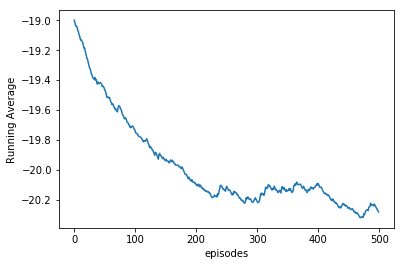

In [7]:
plt.plot(running_rewards)
plt.xlabel('episodes')
plt.ylabel('Running Average')
plt.show()
env.close()

In [9]:
running_rewards

[-19.0,
 -19.009999999999998,
 -19.029899999999998,
 -19.039600999999998,
 -19.039204989999998,
 -19.048812940099996,
 -19.068324810698996,
 -19.077641562592007,
 -19.09686514696609,
 -19.105896495496427,
 -19.124837530541463,
 -19.13358915523605,
 -19.13225326368369,
 -19.140930731046854,
 -19.149521423736385,
 -19.168026209499022,
 -19.186345947404032,
 -19.184482487929994,
 -19.202637663050695,
 -19.220611286420187,
 -19.238405173555986,
 -19.256021121820428,
 -19.263460910602223,
 -19.2808263014962,
 -19.29801803848124,
 -19.315037858096428,
 -19.321887479515464,
 -19.33866860472031,
 -19.35528191867311,
 -19.36172909948638,
 -19.378111808491514,
 -19.3843306904066,
 -19.39048738350253,
 -19.396582509667507,
 -19.38261668457083,
 -19.39879051772512,
 -19.39480261254787,
 -19.410854586422392,
 -19.426746040558168,
 -19.412478580152587,
 -19.41835379435106,
 -19.42417025640755,
 -19.419928553843476,
 -19.415729268305043,
 -19.42157197562199,
 -19.42735625586577,
 -19.443082693307115,

In [10]:
with open('tmp_running_rewards.txt', 'w') as f:
    for item in running_rewards:
        f.write("%s\n" % item)

In [23]:
rr = []
with open('tmp_running_rewards.txt', 'r') as f:
    for item in f.readlines():
        rr.append(float(item.strip()))
rr == running_rewards

True